# WEATHER PREDICTION WITH MACHINE LEARNING FOR CITIES IN TURKEY

Team Name: **WeMac**

Team Members:

**Sezer UĞUZ**
201511213

**Eyüp Can TURGUT**
201411062

**Official Github Web Page of Project:** https://github.com/BilgiSezer/TurkeyWeatherMLPrediction

# Explanation of Project and Terms

We will focus on analyzing the **weather data** from http://climexp.knmi.nl/selectdailyseries.cgi?id=someone@somewhere for **Turkey**. We collected raw data from the **KNMI Climate Explorer** web site. We will analyze the data with the goal of selecting appropriate features for building a **Linear Regression model** using the **statsmodels** and **scikit-learn** Python libraries.

After building a Linear Regression model, we will focus on using **Neural Networks.** We will compare the results between Linear Regression and Neural Network models.

Finally, we will try to do examine for global warming and flooding issues related results of models.

Cities that are we will examine;
**Istanbul, Kastamonu, Sivas, Rize, Van, Antalya and Isparta.**

Years to review;
**1958-2003**

**DPrec:** Daily Precipitation

**DMaxT:** Daily Maximum Temperature

**DMinT:** Daily Minimum Temperature

**DMeanT:** Daily Mean Temperature

### In Brief
In our project, we examined the weather prediction of 7 cities in Turkey, data of years between 1958 and 2003, according to precipitation, mean temperature, minimum temperature and maximum temperature.

## Libraries that We Used
* Using "pandas" library we take the data from text files,
* "numpy" library for scientific calculations,
* "seaborn", "matplotlib.pyplot" and "sklearn" libraries for visualize the datas
* "statsmodels" library for conducting statistical tests, and statistical data exploration

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.regressionplots import abline_plot



# General View of Turkey Map with Our Related Cities

#### In here, we examined the location of our cities that related the project. (Istanbul, Kastamonu, Sivas, Rize, Van, Antalya and Isparta) These are latitudes and longitudes of the cities.

In [2]:
LocationCities = pd.DataFrame({
   'Longitude':[28.58, 33.47, 40.31, 37.02, 43.20, 30.42, 30.33],
   'Latitude':[41.01, 41.22, 41.02, 39.45, 38.28, 36.53, 37.46],
   'CityName':['Istanbul', 'Kastamonu', 'Rize', 'Sivas', 'Van', 'Antalya', 'Isparta']
})

#### We visualizated the cities that we examine.

In [3]:
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    Range1d, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, output_file, show


map_options = GMapOptions(lat=38.9637, lng=35.2433, map_type="terrain", zoom=6)

plot = GMapPlot(
    x_range=Range1d(), y_range=Range1d(), map_options=map_options, plot_width=990, plot_height=800
)
plot.title.text = "Here  on Google Maps for cities in TURKEY!"

plot.api_key = "Write your API Key!" #Your Google Maps API Key

source = ColumnDataSource(
    data=dict(
        lat=LocationCities.Latitude.tolist(),
        lon=LocationCities.Longitude.tolist(),
        color=LocationCities.CityName.tolist()
    )
)

circle = Circle(x="lon", y="lat", size=100, fill_alpha=0.4, line_color="#3288bd", 
                fill_color="white", line_width=7)
plot.add_glyph(source, circle)

output_notebook()

show(plot)

Loading BokehJS ...

# Importing and Editing Data

We took the raw data from KNMI (Koninklijik Nederlands Meteorologisch Instituut) Climate Explorer web site as text files.

#### In this part, we are taking the the data from text files using pandas and we are cleaninig it. At the end of transactions, we wil have clean data between 1958 and 2003.

#### To show how we did it, we are editing the "Daily Minimum Temperatures of İstanbul" as an example. (We did this transactions for every 7 cities and their daily precipitations, minimum,maximum and mean temperaures.)

#### We took the data as a textfile and we saved it in pandas dataframe.

In [4]:
import pandas as pd
from datetime import datetime

Istanbul_DMinT = pd.read_fwf('istanbul_daily_min_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Istanbul_DMinT'))


In [5]:
Istanbul_DMinT.head(2)

,Year,Month,Day,Istanbul_DMinT
0,1929,1,1,9.7
1,1929,1,2,10.2


#### After that we filtered the data between 1958 and 2003.

In [6]:
#Get values of indexes for which column Year less than 1958 or higher than 2003.
Istanbul = Istanbul_DMinT[Istanbul_DMinT['Year'] < 1958].index
#Delete these row indexes from dataFrame
Istanbul_DMinT.drop(Istanbul , inplace=True)

Istanbul = Istanbul_DMinT[Istanbul_DMinT['Year'] > 2003].index
Istanbul_DMinT.drop(Istanbul , inplace=True)

Istanbul_DMinT.head(2)

,Year,Month,Day,Istanbul_DMinT
10592,1958,1,1,6.3
10593,1958,1,2,6.3


#### In here, we merged year, month and day as date. That will make our work easier to visualize data.

In [7]:
Istanbul_DMinT['Date'] = pd.to_datetime(Istanbul_DMinT[['Year', 'Month', 'Day']], 
                                        format='%Y%m%d', errors='coerce')

In [8]:
Istanbul_DMinT.head(2)

,Year,Month,Day,Istanbul_DMinT,Date
10592,1958,1,1,6.3,1958-01-01
10593,1958,1,2,6.3,1958-01-02


#### Then, we change the location of the "Date" column as first. So that we could bring other cities temperatures regularly.

In [9]:
#Adds a new column (df['Date']) and reorders our dataframe so it's at the start now (i.e., the first column).
cols = Istanbul_DMinT.columns.tolist()
Istanbul_DMinT = Istanbul_DMinT[[cols[-1]] + cols[:-1]]

In [10]:
Istanbul_DMinT.head(2)

,Date,Year,Month,Day,Istanbul_DMinT
10592,1958-01-01,1958,1,1,6.3
10593,1958-01-02,1958,1,2,6.3


In [11]:
Date = Istanbul_DMinT['Date']

#### Finally, we dropped the unimportant columns which are day, year and month. These are unimportant, because we have already had merged version of them as named "Date".

In [12]:
Istanbul_DMinT.drop(['Month'],axis=1,inplace=True)
Istanbul_DMinT.drop(['Day'],axis=1,inplace=True)
Istanbul_DMinT.reset_index(drop=True, inplace=True)
Istanbul_DMinT.head(2)

,Date,Year,Istanbul_DMinT
0,1958-01-01,1958,6.3
1,1958-01-02,1958,6.3


#### The dataframe above is last situation of Istanbul Daily Minimum Temperatures.

#### Here, we did the steps that we have just showed. We did all these steps for every cities and every values like daily maximum temperature, daily precipitation, daily mean temperatures, etc.

### Why did we edit the data one by one?
You could ask that why we edited all the data one by one. You can say that it is sensible to create a function that receive the data, so we wouldn't have to write same things again and again.

However, we have so many disorganized data. There are so many text files to edit and each file is different. If there is only one file, it is better to create a function for editing the data, but we have so many files. Thus, we decided that it is better to edit the data one by one.

#### We took the other cities of _daily precipitation_ data as textfiles and we saved them in pandas dataframe. We skipped first 17 rows, because there were unnecessary.

In [13]:
#We will assign the daily precipitation for each city.
Istanbul_DPrec = pd.read_fwf('istanbul_precipitation.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Istanbul_DPrec'))

Kastamonu_DPrec = pd.read_fwf('kastamonu_precipitation.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Kastamonu_DPrec'))

Rize_DPrec = pd.read_fwf('rize_precipitation.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Rize_DPrec'))

Sivas_DPrec = pd.read_fwf('sivas_precipitation.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Sivas_DPrec'))

Van_DPrec = pd.read_fwf('van_precipitation.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Van_DPrec'))

Antalya_DPrec = pd.read_fwf('antalya_precipitation.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Antalya_DPrec'))

Isparta_DPrec = pd.read_fwf('isparta_precipitation.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Isparta_DPrec'))



#### After that we filtered the data between 1958 and 2003.

In [14]:
#Get values of indexes for which column Year less than 1958 or higher than 2003.
Istanbul = Istanbul_DPrec[Istanbul_DPrec['Year'] < 1958].index
Istanbul_DPrec.drop(Istanbul , inplace=True)
Istanbul = Istanbul_DPrec[Istanbul_DPrec['Year'] > 2003].index
Istanbul_DPrec.drop(Istanbul , inplace=True)

Kastamonu = Kastamonu_DPrec[Kastamonu_DPrec['Year'] < 1958].index
Kastamonu_DPrec.drop(Kastamonu , inplace=True)
Kastamonu = Kastamonu_DPrec[Kastamonu_DPrec['Year'] > 2003].index
Kastamonu_DPrec.drop(Kastamonu , inplace=True)

Rize = Rize_DPrec[Rize_DPrec['Year'] < 1958].index
Rize_DPrec.drop(Rize , inplace=True)
Rize = Rize_DPrec[Rize_DPrec['Year'] > 2003].index
Rize_DPrec.drop(Rize , inplace=True)

Sivas = Sivas_DPrec[Sivas_DPrec['Year'] < 1958].index
Sivas_DPrec.drop(Sivas , inplace=True)
Sivas = Sivas_DPrec[Sivas_DPrec['Year'] > 2003].index
Sivas_DPrec.drop(Sivas , inplace=True)

Van = Van_DPrec[Van_DPrec['Year'] < 1958].index
Van_DPrec.drop(Van , inplace=True)
Van = Van_DPrec[Van_DPrec['Year'] > 2003].index
Van_DPrec.drop(Van , inplace=True)

Antalya = Antalya_DPrec[Antalya_DPrec['Year'] < 1958].index
Antalya_DPrec.drop(Antalya , inplace=True)
Antalya = Antalya_DPrec[Antalya_DPrec['Year'] > 2003].index
Antalya_DPrec.drop(Antalya , inplace=True)

Isparta = Isparta_DPrec[Isparta_DPrec['Year'] < 1958].index
Isparta_DPrec.drop(Isparta , inplace=True)
Isparta = Isparta_DPrec[Isparta_DPrec['Year'] > 2003].index
Isparta_DPrec.drop(Isparta , inplace=True)

#### We took the each 7 cities of _daily mean temperature as_ textfiles and we saved them in pandas dataframe. We skipped first 17 rows, because there were unnecessary.

In [15]:
#We will assign the daily mean temperature for each city.
Istanbul_DMeanT = pd.read_fwf('istanbul_daily_mean_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Istanbul_DMeanT'))

Kastamonu_DMeanT = pd.read_fwf('kastamonu_daily_mean_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Kastamonu_DMeanT'))

Rize_DMeanT = pd.read_fwf('rize_daily_mean_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Rize_DMeanT'))

Sivas_DMeanT = pd.read_fwf('sivas_daily_mean_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Sivas_DMeanT'))

Van_DMeanT = pd.read_fwf('van_daily_mean_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Van_DMeanT'))

Antalya_DMeanT = pd.read_fwf('antalya_daily_mean_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Antalya_DMeanT'))

Isparta_DMeanT = pd.read_fwf('isparta_daily_mean_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Isparta_DMeanT'))

#### After that we filtered the data between 1958 and 2003.

In [16]:
#Get values of indexes for which column Year less than 1958 or higher than 2003.
Istanbul = Istanbul_DMeanT[Istanbul_DMeanT['Year'] < 1958].index
Istanbul_DMeanT.drop(Istanbul , inplace=True)
Istanbul = Istanbul_DMeanT[Istanbul_DMeanT['Year'] > 2003].index
Istanbul_DMeanT.drop(Istanbul , inplace=True)

Kastamonu = Kastamonu_DMeanT[Kastamonu_DMeanT['Year'] < 1958].index
Kastamonu_DMeanT.drop(Kastamonu , inplace=True)
Kastamonu = Kastamonu_DMeanT[Kastamonu_DMeanT['Year'] > 2003].index
Kastamonu_DMeanT.drop(Kastamonu , inplace=True)

Rize = Rize_DMeanT[Rize_DMeanT['Year'] < 1958].index
Rize_DMeanT.drop(Rize , inplace=True)
Rize = Rize_DMeanT[Rize_DMeanT['Year'] > 2003].index
Rize_DMeanT.drop(Rize , inplace=True)

Sivas = Sivas_DMeanT[Sivas_DMeanT['Year'] < 1958].index
Sivas_DMeanT.drop(Sivas , inplace=True)
Sivas = Sivas_DMeanT[Sivas_DMeanT['Year'] > 2003].index
Sivas_DMeanT.drop(Sivas , inplace=True)

Van = Van_DMeanT[Van_DMeanT['Year'] < 1958].index
Van_DMeanT.drop(Van , inplace=True)
Van = Van_DMeanT[Van_DMeanT['Year'] > 2003].index
Van_DMeanT.drop(Van , inplace=True)

Antalya = Antalya_DMeanT[Antalya_DMeanT['Year'] < 1958].index
Antalya_DMeanT.drop(Antalya , inplace=True)
Antalya = Antalya_DMeanT[Antalya_DMeanT['Year'] > 2003].index
Antalya_DMeanT.drop(Antalya , inplace=True)

Isparta = Isparta_DMeanT[Isparta_DMeanT['Year'] < 1958].index
Isparta_DMeanT.drop(Isparta , inplace=True)
Isparta = Isparta_DMeanT[Isparta_DMeanT['Year'] > 2003].index
Isparta_DMeanT.drop(Isparta , inplace=True)

#### We took the each 7 cities of _daily minimum temperature_ as textfiles and we saved them in pandas dataframe. We skipped first 17 rows, because there were unnecessary.

In [17]:
#We will assign the daily minimum temperature for each city.

Kastamonu_DMinT = pd.read_fwf('kastamonu_daily_min_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Kastamonu_DMinT'))

Rize_DMinT = pd.read_fwf('rize_daily_min_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Rize_DMinT'))

Sivas_DMinT = pd.read_fwf('sivas_daily_min_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Sivas_DMinT'))

Van_DMinT = pd.read_fwf('van_daily_min_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Van_DMinT'))

Antalya_DMinT = pd.read_fwf('antalya_daily_min_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Antalya_DMinT'))

Isparta_DMinT = pd.read_fwf('isparta_daily_min_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Isparta_DMinT'))

#### After that we filtered the data between 1958 and 2003.

In [18]:
#Get values of indexes for which column Year less than 1958 or higher than 2003.
#Istanbul created before. (above)

Kastamonu = Kastamonu_DMinT[Kastamonu_DMinT['Year'] < 1958].index
Kastamonu_DMinT.drop(Kastamonu , inplace=True)
Kastamonu = Kastamonu_DMinT[Kastamonu_DMinT['Year'] > 2003].index
Kastamonu_DMinT.drop(Kastamonu , inplace=True)

Rize = Rize_DMinT[Rize_DMinT['Year'] < 1958].index
Rize_DMinT.drop(Rize , inplace=True)
Rize = Rize_DMinT[Rize_DMinT['Year'] > 2003].index
Rize_DMinT.drop(Rize , inplace=True)

Sivas = Sivas_DMinT[Sivas_DMinT['Year'] < 1958].index
Sivas_DMinT.drop(Sivas , inplace=True)
Sivas = Sivas_DMinT[Sivas_DMinT['Year'] > 2003].index
Sivas_DMinT.drop(Sivas , inplace=True)

Van = Van_DMinT[Van_DMinT['Year'] < 1958].index
Van_DMinT.drop(Van , inplace=True)
Van = Van_DMinT[Van_DMinT['Year'] > 2003].index
Van_DMinT.drop(Van , inplace=True)

Antalya = Antalya_DMinT[Antalya_DMinT['Year'] < 1958].index
Antalya_DMinT.drop(Antalya , inplace=True)
Antalya = Antalya_DMinT[Antalya_DMinT['Year'] > 2003].index
Antalya_DMinT.drop(Antalya , inplace=True)

Isparta = Isparta_DMinT[Isparta_DMinT['Year'] < 1958].index
Isparta_DMinT.drop(Isparta , inplace=True)
Isparta = Isparta_DMinT[Isparta_DMinT['Year'] > 2003].index
Isparta_DMinT.drop(Isparta , inplace=True)

#### We took the each 7 cities of _daily maximum temperature_ as textfiles and we saved them in pandas dataframe. We skipped first 17 rows, because there were unnecessary.

In [19]:
#We will assign the daily maximum temperature for each city.
Istanbul_DMaxT = pd.read_fwf('istanbul_daily_max_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Istanbul_DMaxT'))

Kastamonu_DMaxT = pd.read_fwf('kastamonu_daily_max_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Kastamonu_DMaxT'))

Rize_DMaxT = pd.read_fwf('rize_daily_max_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Rize_DMaxT'))

Sivas_DMaxT = pd.read_fwf('sivas_daily_max_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Sivas_DMaxT'))

Van_DMaxT = pd.read_fwf('van_daily_max_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Van_DMaxT'))

Antalya_DMaxT = pd.read_fwf('antalya_daily_max_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Antalya_DMaxT'))

Isparta_DMaxT = pd.read_fwf('isparta_daily_max_temp.txt', header=None, 
                 delim_whitespace=True, skiprows=17, names=('Year', 'Month', 'Day', 'Isparta_DMaxT'))

#### After that we filtered the data between 1958 and 2003.

In [20]:
#Get values of indexes for which column Year less than 1958 or higher than 2003.
Istanbul = Istanbul_DMaxT[Istanbul_DMaxT['Year'] < 1958].index
Istanbul_DMaxT.drop(Istanbul , inplace=True)
Istanbul = Istanbul_DMaxT[Istanbul_DMaxT['Year'] > 2003].index
Istanbul_DMaxT.drop(Istanbul , inplace=True)

Kastamonu = Kastamonu_DMaxT[Kastamonu_DMaxT['Year'] < 1958].index
Kastamonu_DMaxT.drop(Kastamonu , inplace=True)
Kastamonu = Kastamonu_DMaxT[Kastamonu_DMaxT['Year'] > 2003].index
Kastamonu_DMaxT.drop(Kastamonu , inplace=True)

Rize = Rize_DMaxT[Rize_DMaxT['Year'] < 1958].index
Rize_DMaxT.drop(Rize , inplace=True)
Rize = Rize_DMaxT[Rize_DMaxT['Year'] > 2003].index
Rize_DMaxT.drop(Rize , inplace=True)

Sivas = Sivas_DMaxT[Sivas_DMaxT['Year'] < 1958].index
Sivas_DMaxT.drop(Sivas , inplace=True)
Sivas = Sivas_DMaxT[Sivas_DMaxT['Year'] > 2003].index
Sivas_DMaxT.drop(Sivas , inplace=True)

Van = Van_DMaxT[Van_DMaxT['Year'] < 1958].index
Van_DMaxT.drop(Van , inplace=True)
Van = Van_DMaxT[Van_DMaxT['Year'] > 2003].index
Van_DMaxT.drop(Van , inplace=True)

Antalya = Antalya_DMaxT[Antalya_DMaxT['Year'] < 1958].index
Antalya_DMaxT.drop(Antalya , inplace=True)
Antalya = Antalya_DMaxT[Antalya_DMaxT['Year'] > 2003].index
Antalya_DMaxT.drop(Antalya , inplace=True)

Isparta = Isparta_DMaxT[Isparta_DMaxT['Year'] < 1958].index
Isparta_DMaxT.drop(Isparta , inplace=True)
Isparta = Isparta_DMaxT[Isparta_DMaxT['Year'] > 2003].index
Isparta_DMaxT.drop(Isparta , inplace=True)

#### Here, we find out that we need the data's of years. So, we decided that it is better to take backups of them. We backupped the data of the _daily precipitation_ and then dropped the unimportant columns which are day and month. 

In [21]:
#We can remove the unimportant columns 'Month' and 'Day' for each city.

Istanbul_DP=Istanbul_DPrec

Istanbul_DPrec.drop(['Month'],axis=1,inplace=True)
Istanbul_DPrec.drop(['Day'],axis=1,inplace=True)
Istanbul_DPrec.reset_index(drop=True, inplace=True)

Kastamonu_DP=Kastamonu_DPrec

Kastamonu_DPrec.drop(['Month'],axis=1,inplace=True)
Kastamonu_DPrec.drop(['Day'],axis=1,inplace=True)
Kastamonu_DPrec.reset_index(drop=True, inplace=True)

Rize_DP=Rize_DPrec

Rize_DPrec.drop(['Month'],axis=1,inplace=True)
Rize_DPrec.drop(['Day'],axis=1,inplace=True)
Rize_DPrec.reset_index(drop=True, inplace=True)

Sivas_DP=Sivas_DPrec

Sivas_DPrec.drop(['Month'],axis=1,inplace=True)
Sivas_DPrec.drop(['Day'],axis=1,inplace=True)
Sivas_DPrec.reset_index(drop=True, inplace=True)

Van_DP=Van_DPrec

Van_DPrec.drop(['Month'],axis=1,inplace=True)
Van_DPrec.drop(['Day'],axis=1,inplace=True)
Van_DPrec.reset_index(drop=True, inplace=True)

Antalya_DP=Antalya_DPrec

Antalya_DPrec.drop(['Month'],axis=1,inplace=True)
Antalya_DPrec.drop(['Day'],axis=1,inplace=True)
Antalya_DPrec.reset_index(drop=True, inplace=True)

Isparta_DP=Isparta_DPrec

Isparta_DPrec.drop(['Month'],axis=1,inplace=True)
Isparta_DPrec.drop(['Day'],axis=1,inplace=True)
Isparta_DPrec.reset_index(drop=True, inplace=True)

#### We backupped the data of the _daily mean temperature_ and then dropped the unimportant columns which are day and month. 

In [22]:
Istanbul_DMean=Istanbul_DMeanT

Istanbul_DMeanT.drop(['Month'],axis=1,inplace=True)
Istanbul_DMeanT.drop(['Day'],axis=1,inplace=True)
Istanbul_DMeanT.reset_index(drop=True, inplace=True)

Kastamonu_DMean=Kastamonu_DMeanT

Kastamonu_DMeanT.drop(['Month'],axis=1,inplace=True)
Kastamonu_DMeanT.drop(['Day'],axis=1,inplace=True)
Kastamonu_DMeanT.reset_index(drop=True, inplace=True)

Rize_DMean=Rize_DMeanT

Rize_DMeanT.drop(['Month'],axis=1,inplace=True)
Rize_DMeanT.drop(['Day'],axis=1,inplace=True)
Rize_DMeanT.reset_index(drop=True, inplace=True)

Sivas_DMean=Sivas_DMeanT

Sivas_DMeanT.drop(['Month'],axis=1,inplace=True)
Sivas_DMeanT.drop(['Day'],axis=1,inplace=True)
Sivas_DMeanT.reset_index(drop=True, inplace=True)

Van_DMean=Van_DMeanT

Van_DMeanT.drop(['Month'],axis=1,inplace=True)
Van_DMeanT.drop(['Day'],axis=1,inplace=True)
Van_DMeanT.reset_index(drop=True, inplace=True)

Antalya_DMean=Antalya_DMeanT

Antalya_DMeanT.drop(['Month'],axis=1,inplace=True)
Antalya_DMeanT.drop(['Day'],axis=1,inplace=True)
Antalya_DMeanT.reset_index(drop=True, inplace=True)

Isparta_DMean=Isparta_DMeanT

Isparta_DMeanT.drop(['Month'],axis=1,inplace=True)
Isparta_DMeanT.drop(['Day'],axis=1,inplace=True)
Isparta_DMeanT.reset_index(drop=True, inplace=True)

#### We backupped the data of the _daily minimum temperature_ and then dropped the unimportant columns which are day and month. 

In [23]:
Kastamonu_DMin=Kastamonu_DMinT

Kastamonu_DMinT.drop(['Month'],axis=1,inplace=True)
Kastamonu_DMinT.drop(['Day'],axis=1,inplace=True)
Kastamonu_DMinT.reset_index(drop=True, inplace=True)

Rize_DMin=Rize_DMinT

Rize_DMinT.drop(['Month'],axis=1,inplace=True)
Rize_DMinT.drop(['Day'],axis=1,inplace=True)
Rize_DMinT.reset_index(drop=True, inplace=True)

Sivas_DMin=Sivas_DMinT

Sivas_DMinT.drop(['Month'],axis=1,inplace=True)
Sivas_DMinT.drop(['Day'],axis=1,inplace=True)
Sivas_DMinT.reset_index(drop=True, inplace=True)

Van_DMin=Van_DMinT

Van_DMinT.drop(['Month'],axis=1,inplace=True)
Van_DMinT.drop(['Day'],axis=1,inplace=True)
Van_DMinT.reset_index(drop=True, inplace=True)

Antalya_DMin=Antalya_DMinT

Antalya_DMinT.drop(['Month'],axis=1,inplace=True)
Antalya_DMinT.drop(['Day'],axis=1,inplace=True)
Antalya_DMinT.reset_index(drop=True, inplace=True)

Isparta_DMin=Isparta_DMinT

Isparta_DMinT.drop(['Month'],axis=1,inplace=True)
Isparta_DMinT.drop(['Day'],axis=1,inplace=True)
Isparta_DMinT.reset_index(drop=True, inplace=True)

#### We backupped the data of the _daily maximum temperature_ and then dropped the unimportant columns which are day and month. 

In [24]:
Istanbul_DMax=Istanbul_DMaxT

Istanbul_DMaxT.drop(['Month'],axis=1,inplace=True)
Istanbul_DMaxT.drop(['Day'],axis=1,inplace=True)
Istanbul_DMaxT.reset_index(drop=True, inplace=True)

Kastamonu_DMax=Kastamonu_DMaxT

Kastamonu_DMaxT.drop(['Month'],axis=1,inplace=True)
Kastamonu_DMaxT.drop(['Day'],axis=1,inplace=True)
Kastamonu_DMaxT.reset_index(drop=True, inplace=True)

Rize_DMax=Rize_DMaxT

Rize_DMaxT.drop(['Month'],axis=1,inplace=True)
Rize_DMaxT.drop(['Day'],axis=1,inplace=True)
Rize_DMaxT.reset_index(drop=True, inplace=True)

Sivas_DMax=Sivas_DMaxT

Sivas_DMaxT.drop(['Month'],axis=1,inplace=True)
Sivas_DMaxT.drop(['Day'],axis=1,inplace=True)
Sivas_DMaxT.reset_index(drop=True, inplace=True)

Van_DMax=Van_DMaxT

Van_DMaxT.drop(['Month'],axis=1,inplace=True)
Van_DMaxT.drop(['Day'],axis=1,inplace=True)
Van_DMaxT.reset_index(drop=True, inplace=True)

Antalya_DMax=Antalya_DMaxT

Antalya_DMaxT.drop(['Month'],axis=1,inplace=True)
Antalya_DMaxT.drop(['Day'],axis=1,inplace=True)
Antalya_DMaxT.reset_index(drop=True, inplace=True)

Isparta_DMax=Isparta_DMaxT

Isparta_DMaxT.drop(['Month'],axis=1,inplace=True)
Isparta_DMaxT.drop(['Day'],axis=1,inplace=True)
Isparta_DMaxT.reset_index(drop=True, inplace=True)

### VISUALIZATION OF WEATHER DATA

'Max Temperature': **pink color**

'Mean Tempature': **brown color**

'Min Tempature': **green color**

#### In here, we visualised the min, max and mean temperature anomalies of İstanbul.
#### From this graphic, we can deduce the temperature anomaly of İstanbul.

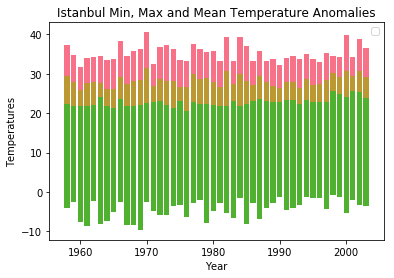

In [25]:
plt.legend(('Max Temperature', 'Mean Tempature', 'Min Tempature'))
plt.title('Istanbul Min, Max and Mean Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperatures')
plt.bar(Istanbul_DMaxT['Year'],Istanbul_DMaxT['Istanbul_DMaxT'])
plt.bar(Istanbul_DMeanT['Year'],Istanbul_DMeanT['Istanbul_DMeanT'])
plt.bar(Istanbul_DMinT['Year'],Istanbul_DMinT['Istanbul_DMinT'])
plt.show()

#### Here, we visualised the min, max and mean temperature anomalies of Kastamonu.
#### From this graphic, we can deduce the temperature anomaly of Kastamonu.

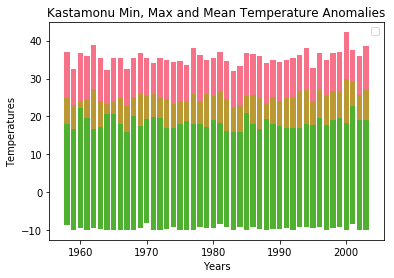

In [26]:
plt.legend(('Max Temperature', 'Mean Tempature', 'Min Tempature'))
plt.title('Kastamonu Min, Max and Mean Temperature Anomalies')
plt.xlabel('Years')
plt.ylabel('Temperatures')
plt.bar(Kastamonu_DMaxT['Year'],Kastamonu_DMaxT['Kastamonu_DMaxT'])
plt.bar(Kastamonu_DMeanT['Year'],Kastamonu_DMeanT['Kastamonu_DMeanT'])
plt.bar(Kastamonu_DMinT['Year'],Kastamonu_DMinT['Kastamonu_DMinT'])
plt.show()

#### Here, we visualised the min, max and mean temperature anomalies of Rize.
#### From this graphic, we can deduce the temperature anomaly of Rize.

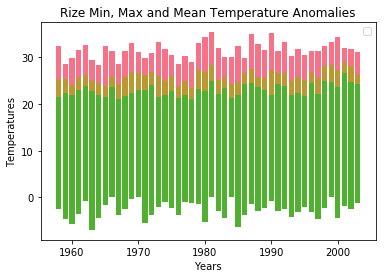

In [27]:
plt.legend(('Max Temperature', 'Mean Tempature', 'Min Tempature'))
plt.title('Rize Min, Max and Mean Temperature Anomalies')
plt.xlabel('Years')
plt.ylabel('Temperatures')
plt.bar(Rize_DMaxT['Year'],Rize_DMaxT['Rize_DMaxT'])
plt.bar(Rize_DMeanT['Year'],Rize_DMeanT['Rize_DMeanT'])
plt.bar(Rize_DMinT['Year'],Rize_DMinT['Rize_DMinT'])
plt.show()

#### Here, we visualised the min, max and mean temperature anomalies of Sivas.
#### From this graphic, we can deduce the temperature anomaly of Sivas.

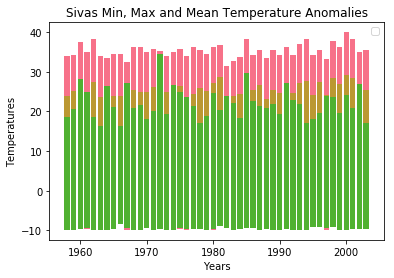

In [28]:
plt.legend(('Max Temperature', 'Mean Tempature', 'Min Tempature'))
plt.title('Sivas Min, Max and Mean Temperature Anomalies')
plt.xlabel('Years')
plt.ylabel('Temperatures')
plt.bar(Sivas_DMaxT['Year'],Sivas_DMaxT['Sivas_DMaxT'])
plt.bar(Sivas_DMeanT['Year'],Sivas_DMeanT['Sivas_DMeanT'])
plt.bar(Sivas_DMinT['Year'],Sivas_DMinT['Sivas_DMinT'])
plt.show()

#### Here, we visualised the min, max and mean temperature anomalies of Van.
#### From this graphic, we can deduce the temperature anomaly of Van.

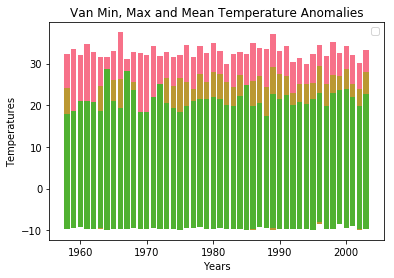

In [29]:
plt.legend(('Max Temperature', 'Mean Tempature', 'Min Tempature'))
plt.title('Van Min, Max and Mean Temperature Anomalies')
plt.xlabel('Years')
plt.ylabel('Temperatures')
plt.bar(Van_DMaxT['Year'],Van_DMaxT['Van_DMaxT'])
plt.bar(Van_DMeanT['Year'],Van_DMeanT['Van_DMeanT'])
plt.bar(Van_DMinT['Year'],Van_DMinT['Van_DMinT'])
plt.show()

#### Here, we visualised the min, max and mean temperature anomalies of Antalya.
#### From this graphic, we can deduce the temperature anomaly of Antalya.

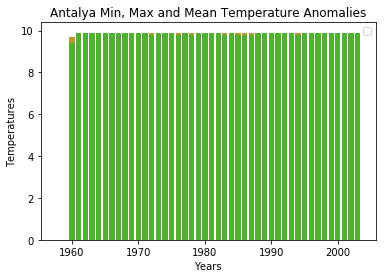

In [30]:
plt.legend(('Max Temperature', 'Mean Tempature', 'Min Tempature'))
plt.title('Antalya Min, Max and Mean Temperature Anomalies')
plt.xlabel('Years')
plt.ylabel('Temperatures')
plt.bar(Antalya_DMaxT['Year'],Antalya_DMaxT['Antalya_DMaxT'])
plt.bar(Antalya_DMeanT['Year'],Antalya_DMeanT['Antalya_DMeanT'])
plt.bar(Antalya_DMinT['Year'],Antalya_DMinT['Antalya_DMinT'])
plt.show()

#### Here, we visualised the min, max and mean temperature anomalies of Isparta.
#### From this graphic, we can deduce the temperature anomaly of Isparta.

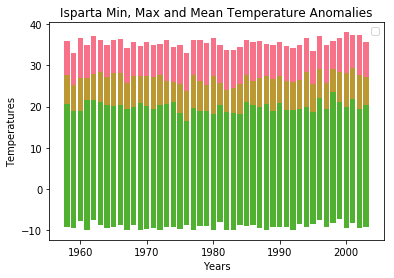

In [31]:
plt.legend(('Max Temperature', 'Mean Tempature', 'Min Tempature'))
plt.title('Isparta Min, Max and Mean Temperature Anomalies')
plt.xlabel('Years')
plt.ylabel('Temperatures')
plt.bar(Isparta_DMaxT['Year'],Isparta_DMaxT['Isparta_DMaxT'])
plt.bar(Isparta_DMeanT['Year'],Isparta_DMeanT['Isparta_DMeanT'])
plt.bar(Isparta_DMinT['Year'],Isparta_DMinT['Isparta_DMinT'])
plt.show()

#### In here, we concatenate all dataframes in one dataframe for each city.

In [32]:
Date['Date'] = Date

IstanbulWeather = pd.concat([
                         Date['Date'],
                         Istanbul_DMinT['Istanbul_DMinT'], 
                         Istanbul_DMaxT['Istanbul_DMaxT'], 
                         Istanbul_DMeanT['Istanbul_DMeanT']
                        ], axis=1)
                        
KastamonuWeather = pd.concat([
                         Date['Date'],
                         Kastamonu_DMinT['Kastamonu_DMinT'], 
                         Kastamonu_DMaxT['Kastamonu_DMaxT'], 
                         Kastamonu_DMeanT['Kastamonu_DMeanT']
                        ], axis=1)

RizeWeather = pd.concat([
                         Date['Date'],
                         Rize_DMinT['Rize_DMinT'],
                         Rize_DMaxT['Rize_DMaxT'],
                         Rize_DMeanT['Rize_DMeanT']
                        ], axis=1)
                        
SivasWeather = pd.concat([
                         Date['Date'],
                         Sivas_DMinT['Sivas_DMinT'],
                         Sivas_DMaxT['Sivas_DMaxT'],
                         Sivas_DMeanT['Sivas_DMeanT']
                        ], axis=1)

VanWeather = pd.concat([
                         Date['Date'],
                         Van_DMinT['Van_DMinT'], 
                         Van_DMaxT['Van_DMaxT'], 
                         Van_DMeanT['Van_DMeanT']
                        ], axis=1)

AntalyalWeather = pd.concat([
                         Date['Date'],
                         Antalya_DMinT['Antalya_DMinT'],
                         Antalya_DMaxT['Antalya_DMaxT'],
                         Antalya_DMeanT['Antalya_DMeanT']
                        ], axis=1)
                        
IspartaWeather = pd.concat([
                         Date['Date'],
                         Isparta_DMinT['Isparta_DMinT'],
                         Isparta_DMaxT['Isparta_DMaxT'],
                         Isparta_DMeanT['Isparta_DMeanT']
                        ], axis=1)
                        

C:\Users\SEZER\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


#### We checked the number of null values here. So, we can see if there is any null data.

In [33]:
IstanbulWeather.isnull().sum()

Date               12145
Istanbul_DMinT     10593
Istanbul_DMaxT     10593
Istanbul_DMeanT    10593
dtype: int64

#### Using info(), we displayed all information of the data. We can see how much entries are there, what are the columns, what are the data times etc.

In [34]:
IstanbulWeather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27394 entries, 10592 to 10591
Data columns (total 4 columns):
Date               15249 non-null object
Istanbul_DMinT     16801 non-null float64
Istanbul_DMaxT     16801 non-null float64
Istanbul_DMeanT    16801 non-null float64
dtypes: float64(3), object(1)
memory usage: 1.0+ MB


#### Here are some statistical values that we will use for data visualization.

In [35]:
IstanbulWeather.describe()

,Istanbul_DMinT,Istanbul_DMaxT,Istanbul_DMeanT
count,16801.000000,16801.000000,16801.000000
mean,10.635843,18.523011,14.579305
std,6.469607,8.068825,7.135048
min,-9.600000,-3.200000,-5.400000
25%,5.400000,12.000000,8.700000
50%,10.700000,18.700000,14.600000
75%,16.000000,25.500000,20.800000
max,25.600000,40.500000,31.400000


# LINEAR REGRESSION

We will focus on analyzing the trends in the data with the goal of selecting appropriate features for building a Linear Regression model using the statsmodels and scikit-learn Python libraries. We will discuss the importance of understanding the assumptions necessary for using a Linear Regression model and demonstrate how to evaluate the features to build a robust model.

In this regard, we have selected quite a few features while parsing the returned daily summary data to be used in our study. However, I fully expect that many of these will prove to be either uninformative in predicting weather temperatures or inappropriate candidates depending on the type of model being used but, the crux is that you simply do not know until you rigorously investigate the data.

As it turns out there are quite a few research articles on the topic and in 2016 Holmstrom, Liu, and Vo they describe using Linear Regression to do just that. In their article, Machine Learning Applied to Weather Forecasting, they used weather data on the prior two days for the following measurements.

    max temperature
    min temperature
    mean humidity
    mean atmospheric pressure

In this project, we will use

    max temperature
    min temperature
    mean temperature


### **Linear Regression of IstanbulWeather**
We will use the 'ols' function from the [statsmodels](http://www.statsmodels.org/stable/index.html) 
package to regress the Mean Tempature on some of the other variables. 
Your model should be of the form:
$$
\text{ŷ} = \beta_0 + \beta_1 x + \beta_(p-n) x(p-n)+ E
$$

$$
\text{Istanbul_DMeanT} = \beta_0 + \beta_1 x 
$$

We'll find that the best predictor of Istanbul_DMeanT.

The generalized formula for a Linear Regression model is:    

where:

** ŷ ** is the predicted outcome variable (dependent variable)

** xj ** are the predictor variables (independent variables) for j = 1,2,..., p-1 parameters

** β0 ** is the intercept or the value of ŷ when each xj equals zero

** βj ** is the change in ŷ based on a one unit change in one of the corresponding xj

** Ε ** is a random error term associated with the difference between the predicted ŷi value and the actual yi value

That last term in the equation for the Linear Regression is a very important one. The most basic form of building a Linear Regression model relies on an algorithm known as Ordinary Least Squares which finds the combination of βj's values which minimize the Ε term.

** Selecting Features for our Model **

A key assumption required by the linear regression technique is that you have a linear relationship between the dependent variable and each independent variable. One way to assess the linearity between our independent variable, which for now will be the mean temperature, and the other independent variables is to calculate the Pearson correlation coefficient.

The Pearson correlation coefficient (r) is a measurement of the amount of linear correlation between equal length arrays which outputs a value ranging -1 to 1. Correlation values ranging from 0 to 1 represent increasingly strong positive correlation. By this I mean that two data series are positively correlated when values in one data series increase simultaneously with the values in the other series and, as they both go up in increasingly equal magnitude the Pearson correlation value will approach 1.

Correlation values from 0 to -1 are said to be inversely, or negatively, correlated in that when the values of one series increase the corresponding values in the opposite series decrease but, as changes in magnitude between the series become equal (with opposite direction) the correlation value will approach -1. Pearson correlation values that closely straddle either side of zero are suggestive to have a weak linear relationship, becoming weaker as the value approaches zero.

Opinions vary among statisticians and stats books on clear-cut boundaries for the levels of strength of a correlation coefficient. However, I have found that a generally accepted set of classifications for the strengths of correlation are as follows:

Correlation Value Interpretation

    0.8 - 1.0 	Very Strong
    0.6 - 0.8 	Strong
    0.4 - 0.6 	Moderate
    0.2 - 0.4 	Weak
    0.0 - 0.2 	Very Weak

To assess the correlation in this data I will call the corr() method of the Pandas DataFrame object. 

In [36]:
# Correlation of DataFrame
IstanbulWeather.corr()

,Istanbul_DMinT,Istanbul_DMaxT,Istanbul_DMeanT
Istanbul_DMinT,1.00000,0.92597,0.97694
Istanbul_DMaxT,0.92597,1.00000,0.98522
Istanbul_DMeanT,0.97694,0.98522,1.00000


**We would like to add to this information (below) by calculating another output column, 
indicating the existence of outliers. The rule of thumb to identifying 
an extreme outlier is a value that is less than 3 interquartile ranges below the 25th percentile, 
or 3 interquartile ranges above the 75th percentile. 
Interquartile range is simply the difference between the 75th percentile and the 25th percentile.
It will help us for prediction.**

In [37]:
# Call describe on df and transpose it due to the large number of columns
spread = IstanbulWeather.describe().T

# precalculate interquartile range for ease of use in next calculation
IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))


In [38]:
spread = IstanbulWeather.describe().T

In [39]:
spread

,count,mean,std,min,25%,50%,75%,max
Istanbul_DMinT,16801.0,10.635843,6.469607,-9.6,5.4,10.7,16.0,25.6
Istanbul_DMaxT,16801.0,18.523011,8.068825,-3.2,12.0,18.7,25.5,40.5
Istanbul_DMeanT,16801.0,14.579305,7.135048,-5.4,8.7,14.6,20.8,31.4


In [40]:
IQR = spread['75%'] - spread['25%']
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))

In [41]:
spread

,count,mean,std,min,25%,50%,75%,max,outliers
Istanbul_DMinT,16801.0,10.635843,6.469607,-9.6,5.4,10.7,16.0,25.6,False
Istanbul_DMaxT,16801.0,18.523011,8.068825,-3.2,12.0,18.7,25.5,40.5,False
Istanbul_DMeanT,16801.0,14.579305,7.135048,-5.4,8.7,14.6,20.8,31.4,False


**Assessing the potential impact of outliers is a difficult part of any analytics project. 
On the one hand, you need to be concerned about the potential for introducing 
spurious data artifacts that will significantly impact or bias your models. 
On the other hand, outliers can be extremely meaningful in predicting outcomes that arise 
under special circumstances. We will discuss each of these outliers containing features 
and see if we can come to a reasonable conclusion as to how to treat them.**

In [42]:
IstanbulWeather = IstanbulWeather.dropna()

The focus of this project will be to describe the processes and steps required to build a rigorous Linear Regression model to predict future mean daily temperature values based off the dataset built in the prior steps. To build the Linear Regression model we will be demonstrating the use of two important Python libraries in the Machine Learning industry: Scikit-Learn and StatsModels.

In [43]:
#OLS Regression
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# The linear regression model
Simple_results = smf.ols('Istanbul_DMeanT ~ Istanbul_DMaxT + Istanbul_DMinT', IstanbulWeather).fit()

# Results
print(Simple_results.summary())

                            OLS Regression Results                            
Dep. Variable:        Istanbul_DMeanT   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.729e+08
Date:                Tue, 15 Jan 2019   Prob (F-statistic):               0.00
Time:                        22:13:07   Log-Likelihood:                 11623.
No. Observations:                5635   AIC:                        -2.324e+04
Df Residuals:                    5632   BIC:                        -2.322e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0006      0.001      0.

** Using SciKit-Learn's LinearRegression Module to Predict the Weather **

Now that we have gone through the steps to select statistically meaningful predictors (features), we can use SciKit-Learn to create a prediction model and test its ability to predict the mean temperature. SciKit-Learn is a very well established machine learning library that is widely used in both industry and academia. One thing that is very impressive about SciKit-Learn is that it maintains a very consistent API of "fit", "predict", and "test" across many numerical techniques and algorithms which makes using it very simple. In addition to this consistent API design, SciKit-Learn also comes with several useful tools for processing data common to many machine learning projects.

We will start by using SciKit-Learn to split our dataset into a testing and training sets by importing the train_test_split() function from sklearn.model_selection module. I will split the training and testing datasets into 80% training and 20% testing and assign a random_state of 12 to ensure we will get the same random selection of data as we do. This random_state parameter is very useful for reproducibility of results.

In [44]:
predictors = IstanbulWeather
X = predictors  
y = IstanbulWeather['Istanbul_DMeanT']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

The next action to take is to build the regression model using the training dataset. To do this we will import and use the LinearRegression class from the sklearn.linear_model module. As mentioned previously, scikit-learn scores major usability bonus points by implementing a common fit() and predict() API across its numerous numerical techniques which makes using the library very user friendly.

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
# instantiate the regressor class
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error  
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))  
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))  
print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))

The Explained Variance: 0.01
The Mean Absolute Error: 6.70 degrees celsius
The Median Absolute Error: 6.85 degrees celsius


As we can see in the few lines of code above using scikit-learn to build a Linear Regression prediction model is quite simple. This is truly where the library shines in its ability to easily fit a model and make predictions about an outcome of interest.

To gain an interpretative understanding of the models validity we used the regressor model's score() function to determine that the model is able to explain about 90% of the variance observed in the outcome variable, mean temperature. Additionally, we used the mean_absolute_error() and median_absolute_error() of the sklearn.metrics module to determine that on average the predicted value is about 7 degrees Celsius off and half of the time it is off by about 7 degrees Celsius.

# Visualizing the Relationships with Multilinear Regression

Linear regression aims to apply a set of assumptions primary regarding linear relationships and numerical techniques to predict an outcome (Y, aka the dependent variable) based off of one or more predictors (X's independent variables) with the end goal of establishing a model (mathematical formula) to predict outcomes given only the predictor values with some amount of uncertainty.

### **Multilinear Regression of IstanbulWeather**
We will use the 'ols' function from the [statsmodels](http://www.statsmodels.org/stable/index.html) 
package to regress the Min Tempature on some of the other variables. 
Your model should be of the form:
$$
\text{Istanbul_DMinT} = \beta_0 + \beta_1 x + +  \beta_2 y
$$
where $x$ is one of the other variables. 

We'll find that the best predictor of Istanbul_DMinT.

In [48]:
# Create a new dataframe for the Processes of Visualization on the Istanbul
# IstanbulW: Istanbul Weather

IstanbulWeather = IstanbulWeather[['Istanbul_DMinT'] + ['Istanbul_DMaxT'] + ['Istanbul_DMeanT']]
IstanbulWeather.head()

,Istanbul_DMinT,Istanbul_DMaxT,Istanbul_DMeanT
10592,8.0,11.5,9.8
10593,7.5,12.2,9.8
10594,4.3,13.3,8.8
10595,0.8,4.6,2.7
10596,-0.2,1.9,0.8


In [49]:
#Correlation between Istanbul_DMinT and other parameters

IstanbulWeather.corr()[['Istanbul_DMinT']].sort_values('Istanbul_DMinT')

,Istanbul_DMinT
Istanbul_DMaxT,0.943959
Istanbul_DMeanT,0.982788
Istanbul_DMinT,1.000000


**We will show relationship between Istanbul Weather Types using Seaborn.**

We are much more accustomed to looking at visuals to assess and verify patterns, I will be graphing each of these selected predictors to prove to myself that there is in fact a linear relationship. To do this we will utilize seaborn module.

For this plot I would like to have the dependent variable "Istanbul_DMinT" be the consistent y-axis along all of the 3 predictor variables plots. One way to accomplish this is to create a grid of plots. We will create a grid structure with three rows of three columns in order to avoid sacrificing clarity in the graphs.

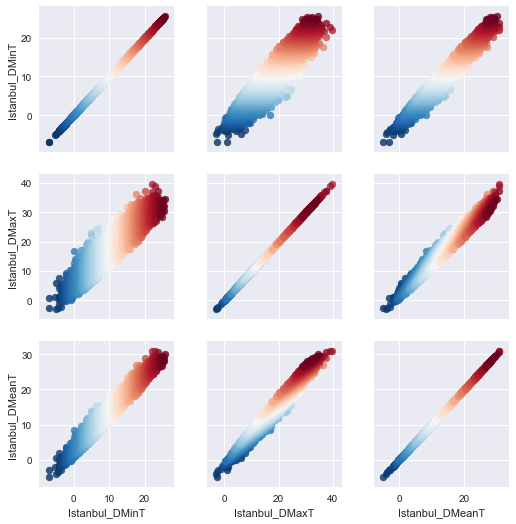

In [50]:
# Seaborn plot for Istanbul Data

import seaborn as sns
sns.set()

g = sns.PairGrid(IstanbulWeather, vars=['Istanbul_DMinT', 'Istanbul_DMaxT', 'Istanbul_DMeanT'],
                 hue='Istanbul_DMinT', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)

From the plots above it is recognizable that all the remaining predictor variables show a good linear relationship with the response variable ("Istanbul_DMinT"). Additionally, it is also worth noting that the relationships all look uniformly randomly distributed. By this we mean there appears to be relatively equal variation in the spread of values devoid of any fanning or cone shape. A uniform random distribution of spread along the points is also another important assumption of Linear Regression using Ordinary Least Squares algorithm.

** Using Step-wise Regression to Build a Robust Model **

A robust Linear Regression model should utilize statistical tests for selecting meaningful, statistically significant, predictors to include. To select statistically significant features, I will utilize the Python statsmodels library. However, before I jump into the practical implementation of using the statsmodels library I would like to take a step back and explain some of the theoretical meaning and purpose for taking this approach.

A key aspect of using statistical methods such as Linear Regression in an analytics project are the establishment and testing of hypothesis tests to validate the significance of assumptions made about the data under study. There are numerous hypothesis tests that have been developed to test the robustness of a linear regression model against various assumptions that are made. One such hypothesis test is to evaluate the significance of each of the included predictor variables.

In [51]:
# The linear regression model for tempature types

IstanbulWeather_results = smf.ols('Istanbul_DMinT ~  + Istanbul_DMaxT + Istanbul_DMeanT', IstanbulWeather).fit()
# Result
print(IstanbulWeather_results.summary())

                            OLS Regression Results                            
Dep. Variable:         Istanbul_DMinT   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.575e+07
Date:                Tue, 15 Jan 2019   Prob (F-statistic):               0.00
Time:                        22:14:25   Log-Likelihood:                 7719.8
No. Observations:                5635   AIC:                        -1.543e+04
Df Residuals:                    5632   BIC:                        -1.541e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0035      0.002     

Ok, We recognize that the call to summary() just barfed out a whole lot of information onto the screen.
We are only going to focus on about 2-3 values in this article:

    P>|t| - this is the p-value I mentioned above that I will be using to evaluate the hypothesis test. This is the value we are going to use to determine whether to eliminate a variable in this step-wise backward elimination technique.
    R-squared - a measure that states how much of the overall variance in the outcome our model can explain
    Adj. R-squared - the same as R-squared but, for multiple linear regression this value has a penalty applied to it based off the number of variables being included to explain the level of overfitting.

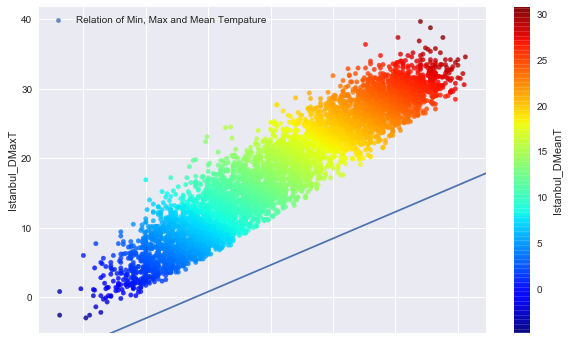

In [52]:
# plot
model = sm.OLS(IstanbulWeather.Istanbul_DMinT, sm.add_constant(IstanbulWeather.Istanbul_DMaxT))

# scatter-plot data
ax = IstanbulWeather.plot(kind='scatter', x='Istanbul_DMinT', y='Istanbul_DMaxT', 
label="Relation of Min, Max and Mean Tempature",
    c="Istanbul_DMeanT", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.8, figsize=(10,6))
# plot regression line
abline_plot(model_results=model.fit(), ax=ax)
    
plt.legend()
plt.show()

# Acknowledgement

**We would like to thank dear Prof. Dr. Erdoğan Doğdu. We learned a lot of information about Python and Data Science. We will continue to improve our knowlegde and we want to be data scientists of future.**

# References

[1] Using Machine Learning to Predict the Weather: Part 1 [Online]. https://stackabuse.com/using-machine-learning-to-predict-the-weather-part-1/

[2] Using Machine Learning to Predict the Weather: Part 2 [Online]. https://stackabuse.com/using-machine-learning-to-predict-the-weather-part-2/

[3] Visualization with Seaborn [Online]. https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html

[4] Mapping Geo Data [Online]. https://bokeh.pydata.org/en/latest/docs/user_guide/geo.html

[5] KNMI Climate Explorer [Online]. http://climexp.knmi.nl/selectdailyseries.cgi?id=someone@somewhere

[6] Data Science Course [Online]. https://github.com/edogdu/